# Data Acquisition and Preprocessing

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose, STL


In [93]:
# Data loading
df = pd.read_csv("NVDA.csv")

In [94]:
# Display the first 5 and last 5 rows of the DataFrame
pd.concat([df.head(5), df.tail(5)])

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,0.984375,0.992188,0.919271,0.975260,0.894608,30091200
1,2000-01-04,0.958333,0.960938,0.901042,0.949219,0.870721,30048000
2,2000-01-05,0.921875,0.937500,0.904948,0.917969,0.842055,18835200
3,2000-01-06,0.917969,0.917969,0.822917,0.858073,0.787112,12048000
4,2000-01-07,0.854167,0.881510,0.841146,0.872396,0.800251,7118400
6111,2024-04-18,849.700012,861.900024,824.020020,846.710022,846.710022,44726000
6112,2024-04-19,831.500000,843.239990,756.059998,762.000000,762.000000,87190500
6113,2024-04-22,781.039978,800.729980,764.000000,795.179993,795.179993,59634100
6114,2024-04-23,807.690002,827.690002,802.640015,824.229980,824.229980,43855900
6115,2024-04-24,839.500000,840.820007,791.830017,796.770020,796.770020,50961600


<Axes: xlabel='Date', ylabel='Close'>

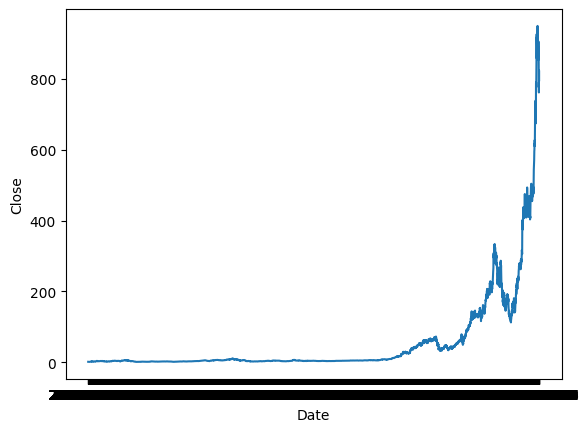

In [95]:
sns.lineplot(x='Date', y='Close', data=df)

In [113]:
df['mean'] = df['Close'].rolling(window=365).mean()
df['std_dev'] = df['Close'].rolling(window=365).std()

<Axes: xlabel='Date', ylabel='mean'>

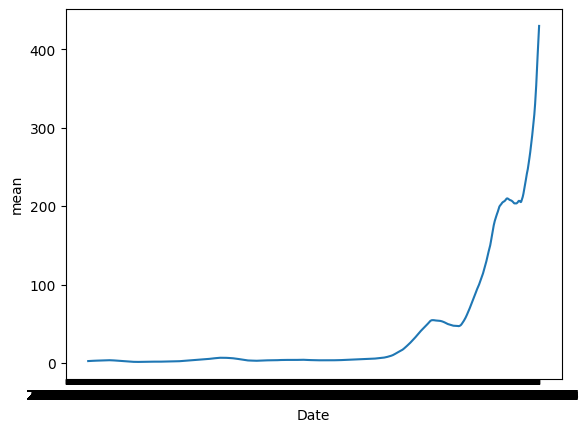

In [114]:
sns.lineplot(x='Date', y='mean', data=df)

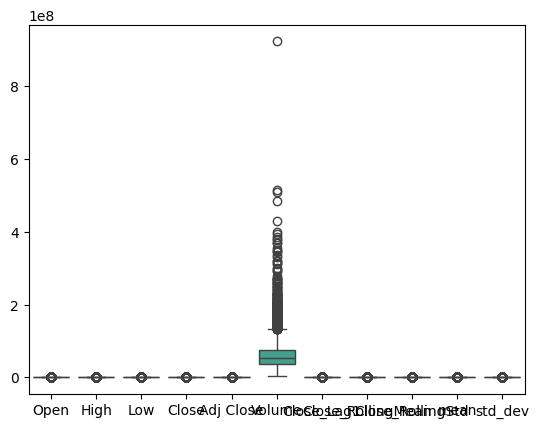

In [118]:
#  Plot a boxplot for each feature
sns.boxplot(data=df)
plt.show()

<Axes: xlabel='Date', ylabel='std_dev'>

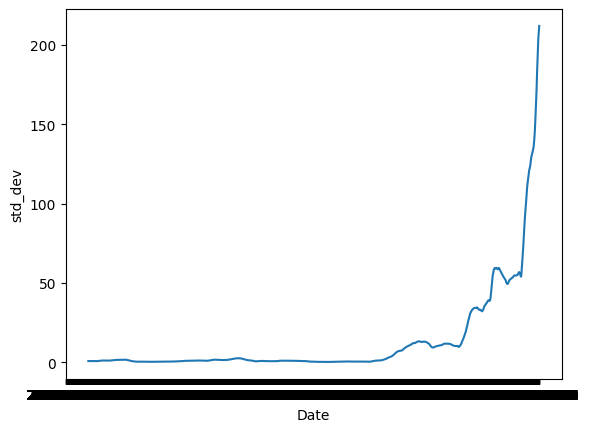

In [116]:
sns.lineplot(x='Date', y='std_dev', data=df)

In [96]:
# Check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [97]:
# Feature Engineering: Create lag features and rolling statistics
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_RollingMean'] = df['Close'].rolling(window=5).mean()
df['Close_RollingStd'] = df['Close'].rolling(window=5).std()

In [98]:
# Drop any rows with missing values created by lag/rolling features
df.dropna(inplace=True)

In [99]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Close_Lag1,Close_RollingMean,Close_RollingStd
count,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6.112000e+03,6112.000000,6112.000000,6112.000000
mean,53.086367,54.051929,52.065172,53.098863,52.828249,6.224516e+07,52.968642,52.836983,1.404784
std,121.299685,123.456900,118.866794,121.215543,121.247240,4.316900e+07,120.843442,120.407565,3.740523
min,0.608333,0.656667,0.600000,0.614167,0.563377,4.564400e+06,0.614167,0.641833,0.004809
25%,2.962109,3.030000,2.876875,2.953125,2.709403,3.617888e+07,2.952500,2.946018,0.059185
50%,4.687500,4.750000,4.612083,4.686250,4.389642,5.208780e+07,4.683750,4.679083,0.124458
75%,42.109374,42.651875,41.525000,42.121250,41.797817,7.466370e+07,42.102499,41.823375,0.724061
max,958.510010,974.000000,935.099976,950.020020,950.020020,9.230856e+08,950.020020,927.317993,57.173366


In [100]:
print(df.shape)

(6112, 10)


In [101]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Close_Lag1', 'Close_RollingMean', 'Close_RollingStd']])

In [102]:
# Create a DataFrame from scaled data
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=['Close', 'Close_Lag1', 'Close_RollingMean', 'Close_RollingStd'])

In [103]:
# Splitting the dataset
train_size = int(len(scaled_df) * 0.8)
train_df, test_df = scaled_df.iloc[:train_size], scaled_df.iloc[train_size:]

In [104]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [105]:
time_step = 5
X_train, y_train = create_dataset(train_df.values, time_step)
X_test, y_test = create_dataset(test_df.values, time_step)

In [106]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# Model Selection and Training

In [108]:
# LSTM Model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(150, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100
123/123 [==============================] - 9s 30ms/step - loss: 1.7925e-05 - val_loss: 6.7423e-04
Epoch 2/100
123/123 [==============================] - 3s 23ms/step - loss: 6.1849e-07 - val_loss: 1.0453e-05
Epoch 3/100
123/123 [==============================] - 4s 31ms/step - loss: 8.2991e-08 - val_loss: 4.4876e-06
Epoch 4/100
123/123 [==============================] - 4s 33ms/step - loss: 6.5340e-08 - val_loss: 4.2317e-06
Epoch 5/100
123/123 [==============================] - 3s 24ms/step - loss: 6.6640e-08 - val_loss: 4.2560e-06
Epoch 6/100
123/123 [==============================] - 3s 24ms/step - loss: 6.8809e-08 - val_loss: 4.0061e-06
Epoch 7/100
123/123 [==============================] - 3s 28ms/step - loss: 9.1360e-08 - val_loss: 6.3048e-06
Epoch 8/100
123/123 [==============================] - 4s 32ms/step - loss: 9.2915e-08 - val_loss: 3.9159e-06
Epoch 9/100
123/123 [==============================] - 3s 23ms/step - loss: 1.0520e-07 - val_loss: 5.6135e-06
Epoch 10/1

In [117]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 5, 150)            93000     
                                                                 
 lstm_31 (LSTM)              (None, 150)               180600    
                                                                 
 dense_31 (Dense)            (None, 25)                3775      
                                                                 
 dense_32 (Dense)            (None, 1)                 26        
                                                                 
Total params: 277401 (1.06 MB)
Trainable params: 277401 (1.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Evaluation and Prediction

In [109]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original scale
train_predict = scaler.inverse_transform(np.concatenate([train_predict, np.zeros((train_predict.shape[0], scaled_df.shape[1] - 1))], axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate([test_predict, np.zeros((test_predict.shape[0], scaled_df.shape[1] - 1))], axis=1))[:,0]
y_train_actual = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_df.shape[1] - 1))], axis=1))[:,0]
y_test_actual = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_df.shape[1] - 1))], axis=1))[:,0]

# Evaluate the model
train_mae = mean_absolute_error(y_train_actual, train_predict)
test_mae = mean_absolute_error(y_test_actual, test_predict)
train_mse = mean_squared_error(y_train_actual, train_predict)
test_mse = mean_squared_error(y_test_actual, test_predict)

print(f'Train MAE: {train_mae}, Train MSE: {train_mse}')
print(f'Test MAE: {test_mae}, Test MSE: {test_mse}')


39/39 [==============================] - 0s 10ms/step
Train MAE: 0.40581541891748296, Train MSE: 0.8210661784025115
Test MAE: 21.31130927127024, Test MSE: 1980.162904209551


# Visualization

In [110]:
print(len(train_index), len(y_train_actual))
print(len(test_index), len(y_test_actual))
print(len(train_index), len(train_predict))
print(len(test_index), len(test_predict))


4883 4883
1217 1217
4883 4883
1217 1217


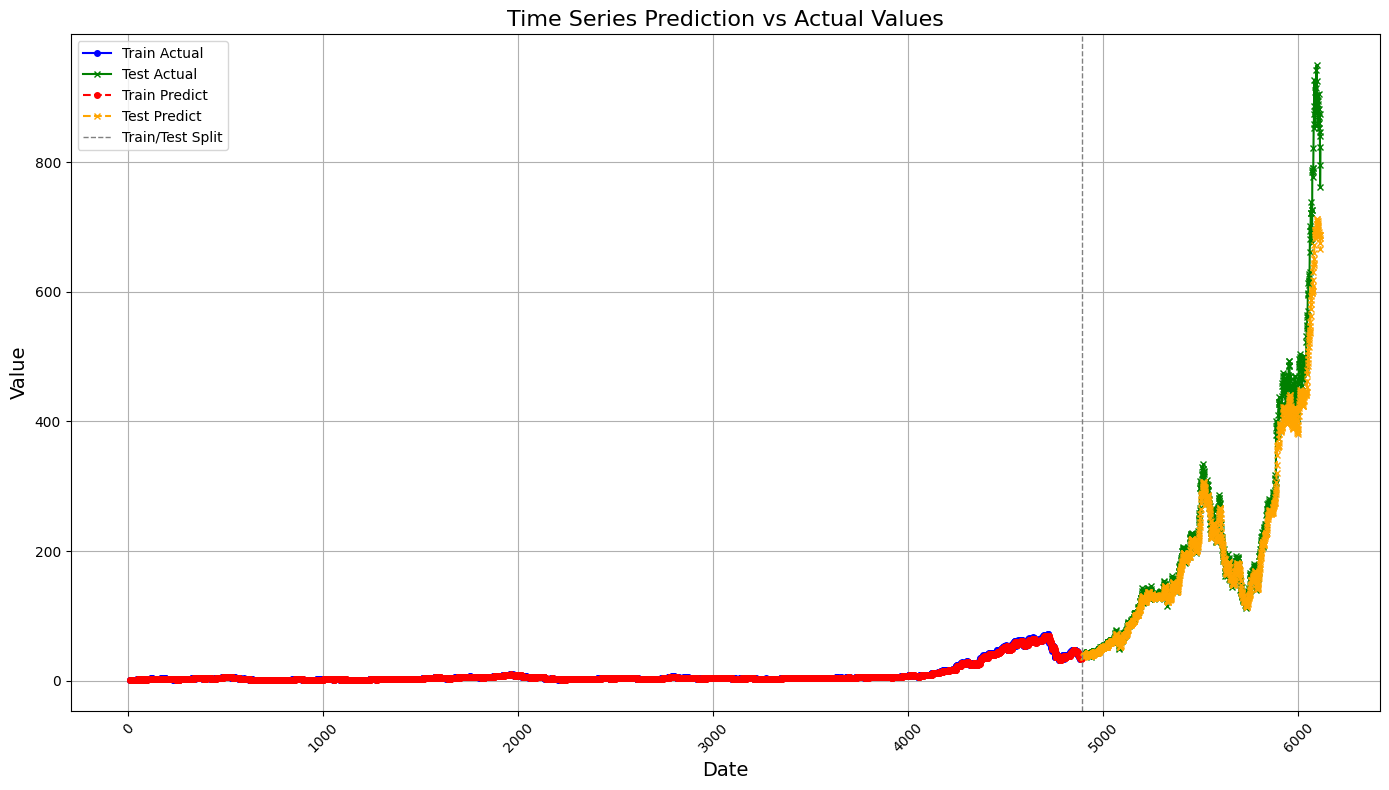

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))


# Plot actual values
plt.plot(train_index, y_train_actual, label='Train Actual', color='blue', linestyle='-', marker='o', markersize=4)
plt.plot(test_index, y_test_actual, label='Test Actual', color='green', linestyle='-', marker='x', markersize=4)

# Plot predictions
plt.plot(train_index, train_predict, label='Train Predict', color='red', linestyle='--', marker='o', markersize=4)
plt.plot(test_index, test_predict, label='Test Predict', color='orange', linestyle='--', marker='x', markersize=4)

# Highlight training and testing periods
plt.axvline(x=train_index[-1], color='gray', linestyle='--', linewidth=1, label='Train/Test Split')

# Add grid
plt.grid(True)

# Add titles and labels
plt.title('Time Series Prediction vs Actual Values', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


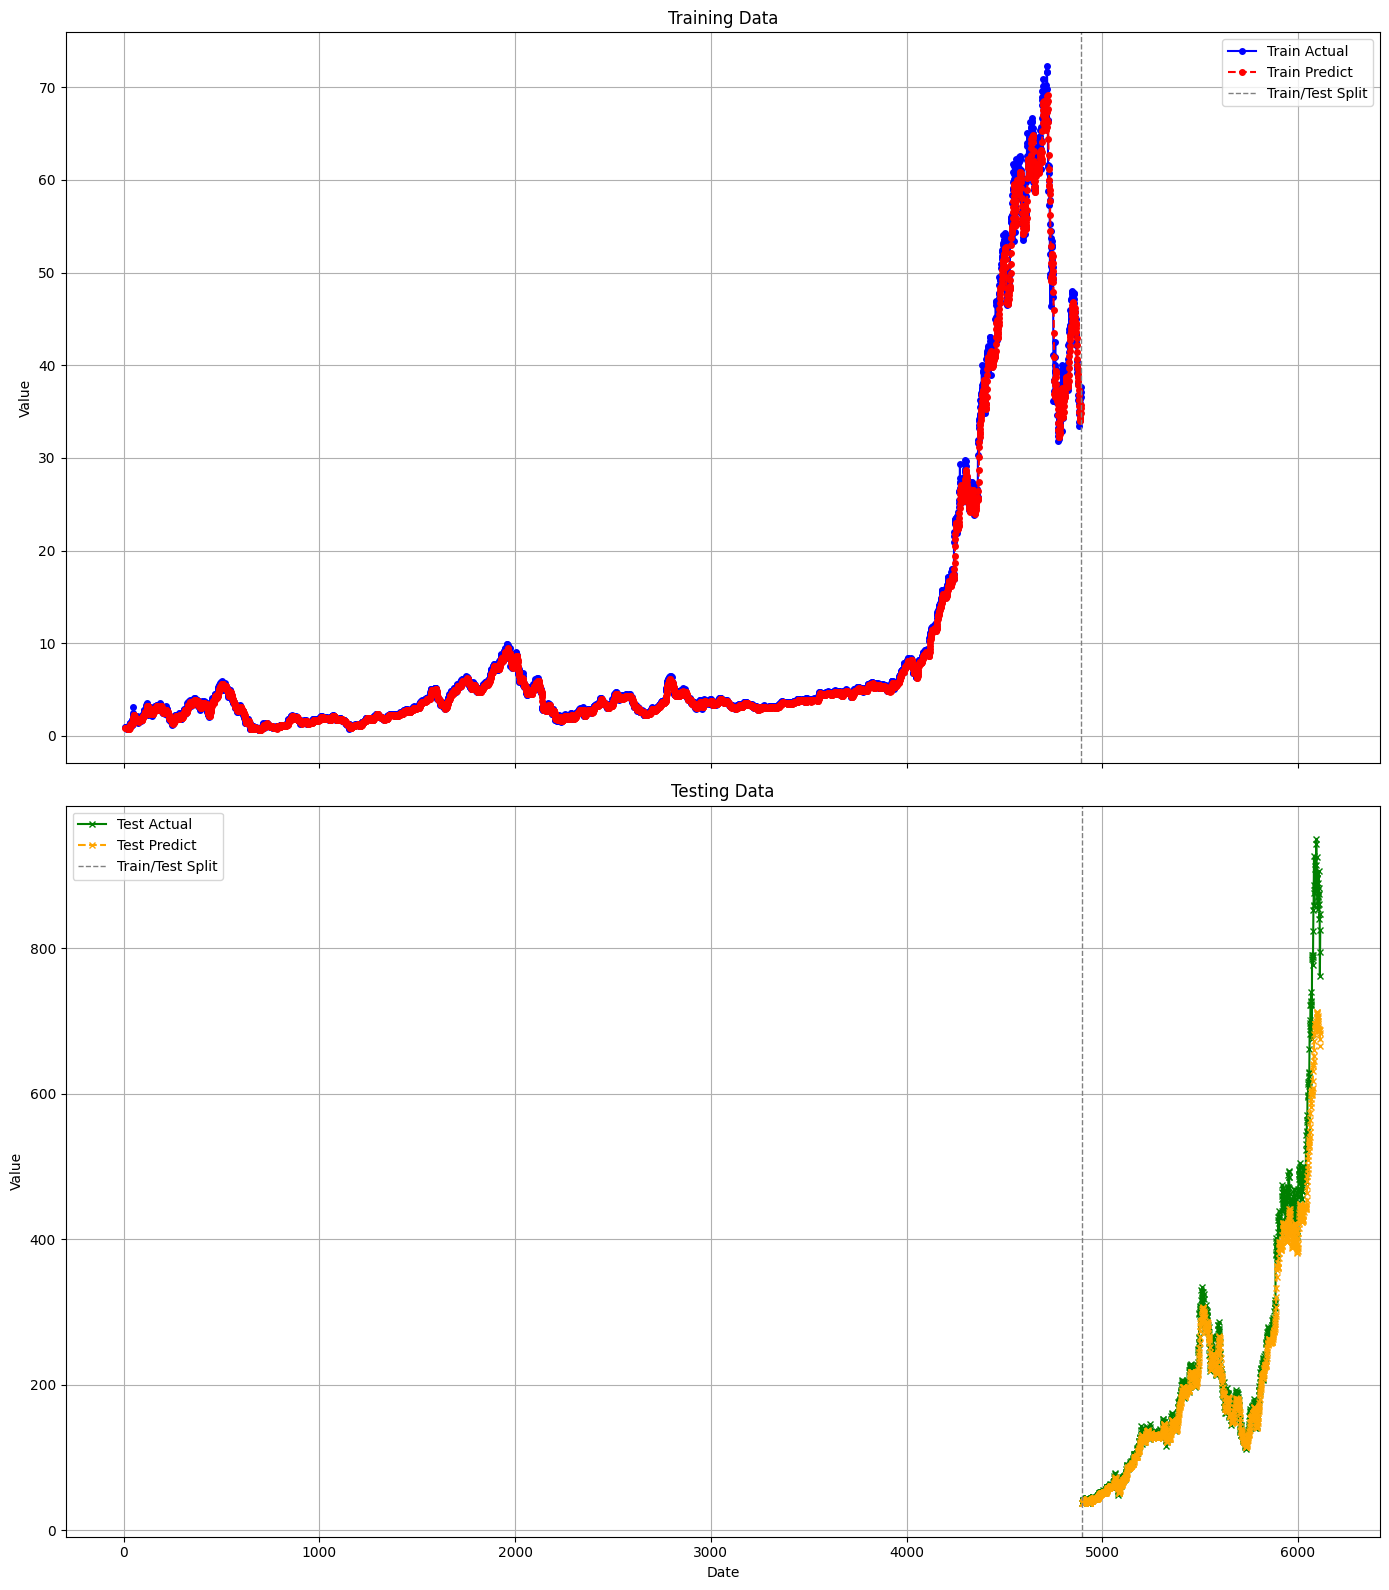

In [112]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

# Plot for Training Data
axs[0].plot(train_index, y_train_actual, label='Train Actual', color='blue', linestyle='-', marker='o', markersize=4)
axs[0].plot(train_index, train_predict, label='Train Predict', color='red', linestyle='--', marker='o', markersize=4)
axs[0].axvline(x=train_index[-1], color='gray', linestyle='--', linewidth=1, label='Train/Test Split')
axs[0].grid(True)
axs[0].set_title('Training Data')
axs[0].set_ylabel('Value')
axs[0].legend()


# Plot for Testing Data
axs[1].plot(test_index, y_test_actual, label='Test Actual', color='green', linestyle='-', marker='x', markersize=4)
axs[1].plot(test_index, test_predict, label='Test Predict', color='orange', linestyle='--', marker='x', markersize=4)
axs[1].axvline(x=test_index[0], color='gray', linestyle='--', linewidth=1, label='Train/Test Split')
axs[1].grid(True)
axs[1].set_title('Testing Data')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Value')
axs[1].legend()


# Adjust layout to prevent overlap
plt.tight_layout()